In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch import nn#contains all of pytorch's building blocks for neural networks
%matplotlib inline

## 1.Data (prepairing and loading)

Data can be almost anything

Machine Learning is a game of two part:
1. Get data to numerical representation.
2. Build a model to learn patterns in that numerical representation.



In [2]:
#Create *know* parameters
weight=0.7
bias=0.3

#Create
start=0
end=1
step=0.02
X=torch.arange(start,end,step).unsqueeze(dim=1)
y=weight*X+bias


## Splitting data into training and test set 

In [3]:
#Create 
train_split=int(0.8*len(X))
X_train,y_train,X_test,y_test=X[:train_split],y[:train_split],X[train_split:],y[train_split:]

In [4]:
def plot_predictions(train_data=X_train
                     ,train_lables=y_train
                     ,test_data=X_test
                     ,test_lables=y_test
                     ,predictions=None):
    """
    Plots training data,test data and compares predictions
    """
    plt.figure(figsize=(6,6))
    #plot train data in blue
    plt.scatter(train_data,train_lables,c='b',s=20,label="Training Data")
     #plot test data in green
    plt.scatter(test_data,test_lables,c='g',s=20,label="Testing Data")

    if predictions is not None:
        #plot the predictions if they exist
        plt.scatter(test_data,predictions,c='r',s=20,label="Predictions")
    #show legend
    plt.legend(prop={'size':14})
        
    

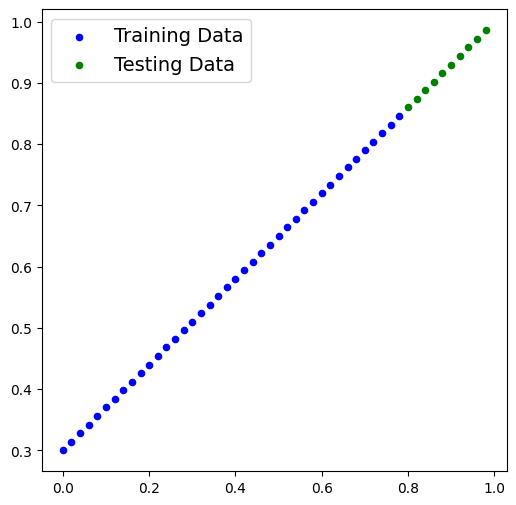

In [5]:
plot_predictions()

## 2.Build model

In [6]:
from torch import nn
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights=nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        self.bias=nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
    #Forward method to define the computation in the model
    def forward(self,x:torch.Tensor)-> torch.Tensor:
        return self.weights*x+self.bias

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data 

![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

> **Resource:** See more of these essential modules and their use cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html). 



### Checking the contents of a PyTorch model
Now we've got these out of the way, let's create a model instance with the class we've made and check its parameters using [`.parameters()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters). 

In [7]:
# create a rando, seed
torch.manual_seed(42)
#create an instance of the model
model_0=LinearRegressionModel()

In [8]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making prediction using `torch.inference_mode()`
to check our model predective power let's see how  well it predicts `y_test` based on `X_test`.

when we pass data through our model, it's going to run it through the `forward()` method

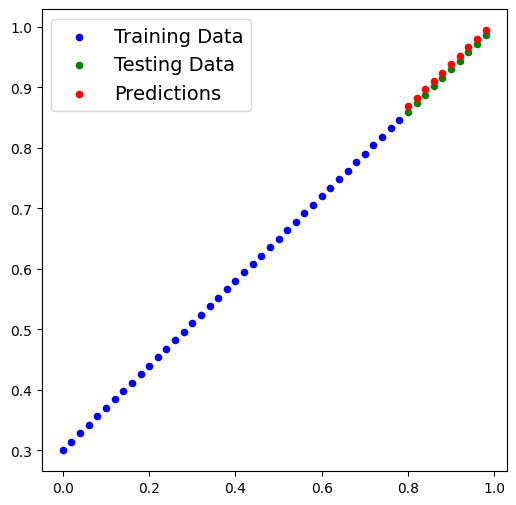

In [14]:
#Make prediction with model
with torch.inference_mode():
    y_preds=model_0(X_test)
plot_predictions(predictions=y_preds)
    

## 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to *parameters* as patterns), the `weights` and `bias` values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

We could hard code this (since we know the default values `weight=0.7` and `bias=0.3`) but where's the fun in that?

Much of the time you won't know what the ideal parameters are for a model.

Instead, it's much more fun to write code to see if the model can try and figure them out itself.



In [10]:
loss_fn=nn.L1Loss()
optimizer=torch.optim.SGD(params=model_0.parameters(),
                         lr=0.01)#lr=learning rate

In [11]:
#An epoch is one loop through the data 

epochs=200

epoch_count=[]
train_loss_value=[]
test_loss_value=[]
# 0.Loop through the data 
for epoch in range(epochs):
    #set the model in training mode 
    model_0.train() #train mode in pytorch sets all parameters that require gradients to require gradients
    #1 forward pass
    y_pred=model_0(X_train)
    #2 calculate the loss 
    loss=loss_fn(y_pred,y_train)
    #3 optimizing zero grade 
    optimizer.zero_grad()
    #4 perform backpropagation on the loss with respect to the parameters of the model 
    loss.backward()
    #5 step the optimizer (perform gradient descent )
    optimizer.step()
    ###Testing
    model_0.eval()# turns off diffrent settings in the model not needed for testing
    with torch.inference_mode():#turns of diffrent things unused in testing for faster result
        #1.Do the forward pass
        test_pred=model_0(X_test)
        #2. Calculating the loss
        test_loss=loss_fn(test_pred,y_test)
    if epoch%30==0:
        epoch_count.append(epoch)
        test_loss_value.append(test_loss)
        train_loss_value.append(loss)
        print(f'epoch:{epoch}|loss:{loss}|Test Loss{test_loss}')
        print(model_0.state_dict())
        print('****************************************************************')

        
        
        
    
    
    ##

epoch:0|loss:0.31288138031959534|Test Loss0.48106518387794495
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
****************************************************************
epoch:30|loss:0.053148526698350906|Test Loss0.14464017748832703
OrderedDict({'weights': tensor([0.4512]), 'bias': tensor([0.3768])})
****************************************************************
epoch:60|loss:0.03818932920694351|Test Loss0.08886633068323135
OrderedDict({'weights': tensor([0.5116]), 'bias': tensor([0.3788])})
****************************************************************
epoch:90|loss:0.02788739837706089|Test Loss0.06473556160926819
OrderedDict({'weights': tensor([0.5629]), 'bias': tensor([0.3573])})
****************************************************************
epoch:120|loss:0.01758546568453312|Test Loss0.04060482233762741
OrderedDict({'weights': tensor([0.6141]), 'bias': tensor([0.3358])})
****************************************************************
epoch:150|loss

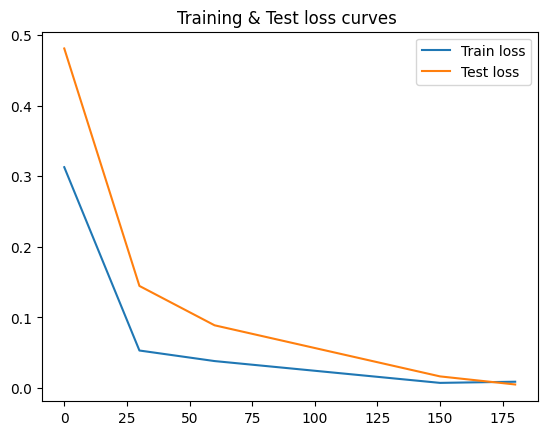

In [12]:
plt.plot(epoch_count,np.array(torch.tensor(train_loss_value).numpy()),label="Train loss")
plt.plot(epoch_count,test_loss_value,label="Test loss")
plt.title('Training & Test loss curves ')
plt.ylabel=('Loss')
plt.xlabel=('Epoch')
plt.legend()

## Saving model in pytorch
1.`torch.save()`

2.`torch.load()`

3.`torch.nn.Module.load_state_dict()`


In [18]:
#saving our pytorch model
from pathlib import Path

#1.Create models directory 
MODEL_PATH=Path("Models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)
#Create model save path
MODEL_NAME="Section_01_LinearModel.pth"
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME
print(f"Saving model to  {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),f=MODEL_SAVE_PATH)


Saving model to  Models\Section_01_LinearModel.pth


In [24]:
loaded_model=LinearRegressionModel()
print(loaded_model.state_dict())
loaded_model.state_dict=torch.load(MODEL_SAVE_PATH)

OrderedDict({'weights': tensor([2.2082]), 'bias': tensor([-0.6380])})


In [25]:
loaded_model.state_dict

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])